In [1]:
# mount google drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import tensorflow as tf
import numpy as np
import re
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Input, dot, Activation, TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras import backend as K
import tensorflow.keras
import matplotlib.pyplot as plt
import nltk
import io
from nltk.tokenize.toktok import ToktokTokenizer
import unicodedata
from sklearn.model_selection import train_test_split

# plot japanese lang
!pip install japanize-matplotlib
import japanize_matplotlib
# ignore warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# load text file

**this dataset is aleady implemented a SentenceSpace**

In [0]:
num_example = 10000

# create each languages list
def create_lang_list(num_example):
    # load txt file
    lines =  io.open("/content/drive/My Drive/Colab Notebooks/raw.txt", encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[w for w in l.split('\t')]  for l in lines[:num_example]]

    return zip(*word_pairs)

In [0]:
en, ja = create_lang_list(num_example)

# Text Pre-processing

**Removing accented characters** 

e.g. é → e.

**Expanding Contractions** 

e.g. don't → do not, I'd → I would

**remove special word** 

e.g. remove "123#@"

**Stemming**

 e.g. corder, codes → code

**Lemmatization**

 e.g. better → good

**Tokenize**

 e.g. I am going to restaurant → [[I], [am], [going], [to], [restaurant]]

# Removing accented characters

English might have accent like é but Japanese doesn't have any accent I just create different function to ascii for Japanese and English

In [0]:
# Removing accented characters
def english_unicode_to_ascii(text):
     return ''.join(ascii_text for ascii_text in unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore'))

def japanese_unicode_to_ascii(text):
    return ''.join(ascii_text for ascii_text in unicodedata.normalize('NFKD', text))

In [5]:
# e.g.
japanese_unicode_to_ascii("こんにちは。今日は"), english_unicode_to_ascii("Hello world é ")

('こんにちは。今日は', 'Hello world e ')

# Expanding Contractions
Japanese doesn't have a Contraction words so I just create a one function to expand Contractions for Engish

In [0]:
def expand_constraction(text):

    #  dic for expand constraction words
    constraction_dict= {
        "ain't": "is not",
        "aren't": "are not",
        "can't": "cannot",
        "can't've": "cannot have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "I'd": "I would",
        "I'd've": "I would have",
        "I'll": "I will",
        "I'll've": "I will have",
        "I'm": "I am",
        "I've": "I have",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
    }

    #  define match pattern
    #  IGNORECASE → no matter if word is lowercase or uppercase
    #  DOTAIL → . is going to match \n
    contraction_pattern = re.compile('({})'.format('|'.join(constraction_dict.keys())),
                                                  flags=re.IGNORECASE | re.DOTALL)
    #  expand words
    def expand_match(constraction):
        # get constraction word
        match = constraction.group(0)
        first_char = match[0]
        #  get expand word from constraction dict
        expand_constraction = constraction_dict.get(match)\
                                                    if constraction_dict.get(match) \
                                                    else constraction_dict.get(match.lower())
        
        # create expand constraction
        expand_constraction = first_char + expand_constraction[1:]
        return expand_constraction
    
    expanded_text = contraction_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [7]:
# e.g.
expand_constraction("you're good I'd like to go he's she's")

'you are good I would like to go he is she is'

# remove special characters and create space between word and punctuation

replacing everything with space except(a-z, A-Z, "?", "!", "-", "ー", "Kanji", "Katakana", "Hiragana") 
create space between word and punctuation (? ! )

In [0]:
def replace_special_character_to_space(text):
    pattern = r"[^a-zA-Z\u3041-\u309F\u30A1-\u30FF\uFF66-\uFF9F\u4E00-\u9FD0\u309B\u3099\uFF9E\u309C\u309A\uFF9F?!\-/\s]+"
    text = re.sub(pattern, '', text).rstrip().strip()
    text = text.replace("・" , "")

    text = re.sub(r"([?!.,。、])", r" \1 ", text)
    text = text.lower()

    return text

In [9]:
# e.g.
replace_special_character_to_space("hello, . #@…123world."), replace_special_character_to_space("こん・にちは。・ いい天気。")

('hello  world', 'こんにちは いい天気')

# Stemming and Lemmatization
I will do stemming only english which can create a base form of a word from a given word. Japanese language doesn't need a stemming

In [0]:
def stemmer_word(text):
    ps = nltk.stem.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [11]:
# e.g.
stemmer_word("hello world she has cat but he had dogs he is went to traveling")

'hello world she ha cat but he had dog he is went to travel'

# Normalize each word

In [0]:
def normalize_english(english_text, japanese_text):
    
    input_value = ()
    target_value = ()
    
    for en_text, ja_text in zip(english_text, japanese_text):
        
        # normalize English
        en_text = english_unicode_to_ascii(en_text)
        en_text = expand_constraction(en_text)
        en_text = replace_special_character_to_space(en_text)

        # input value doesn't need  a START and END sentence  
        input_value += (en_text, )

        # normalize Japanese
        ja_text = japanese_unicode_to_ascii(ja_text)
        ja_text = expand_constraction(ja_text)
        ja_text = replace_special_character_to_space(ja_text)

        # add StTART and END sentence
        ja_text = "START_ " + ja_text + " _END"
        
        target_value += (ja_text, )

    return input_value, target_value

# get clean text data

In [0]:
# get normalize text data
input_value, target_value = normalize_english(en, ja)

# convert to Series
x = pd.Series(input_value) 
y = pd.Series(target_value)

In [14]:
pd.DataFrame({"input": x, "target": y}).head()

,input,target
0,you are back are not you harold ?,START_ あなたは戻ったのね ハロルド ? _END
1,my opponent is shark,START_ 俺の相手は シャークだ _END
2,this is one thing in exchange for another,START_ 引き換えだ ある事とある物の _END
3,yeah i am fine,START_ もういいよ ごちそうさま ううん _END
4,do not come to the office anymore do not call ...,START_ もう会社には来ないでくれ 電話もするな _END


In [15]:
# get unique vocab

# input value 
all_eng = set()
for input_lang in x:
    for word in input_lang.split():
        if word not in all_eng:
            all_eng.add(word)

# target value
all_ja = set()
for target_lang in y:
    for word in target_lang.split():
        if word not in all_ja:
            all_ja.add(word)

print("unique vocab %d" % len(all_eng))
print("unique vocab %d" %len(all_ja))

unique vocab 8667
unique vocab 14897


english length: 40
japanese length: 12


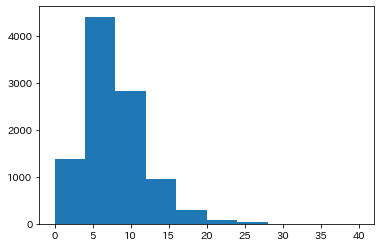

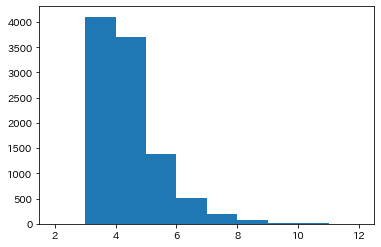

In [16]:
# max length of input sentense and target sentense
english_len = [len(i.split()) for i in x]

japanese_len = [len(i.split()) for i in y]

plt.figure()
plt.hist(english_len)

plt.figure()
plt.hist(japanese_len)

# print max length
print("english length:", max(english_len))
print("japanese length:", max(japanese_len))
max_len_input =  max(english_len)
max_len_target =  max(japanese_len)

In [17]:
input_word = sorted(list(all_eng))
target_word = sorted(list(all_ja))

num_encoder_tokens = len(all_eng)
num_decoder_tokens = len(all_ja)
num_encoder_tokens, num_decoder_tokens

(8667, 14897)

In [0]:
num_decoder_tokens += 1
num_encoder_tokens += 1

In [0]:
input_token_index = dict([ (word, i+1) for i, word in enumerate(input_word)])
target_token_index = dict([ (word, i+1) for i, word in enumerate(target_word)])

In [0]:
reverse_input_char = dict((i, word) for word, i in input_token_index.items())
reverse_target_char = dict((i, word) for word, i in target_token_index.items())

In [21]:
len(y) * max_len_target*num_decoder_tokens

1787760000

In [0]:
# initialize
encoder_input_data = np.zeros((len(x), max_len_input), dtype="float32")
decoder_input_data = np.zeros((len(y), max_len_target), dtype="float32")
decoder_target_data = np.zeros((len(y), max_len_target, num_decoder_tokens), dtype="float32")

In [0]:
for i, (input_text, target_text) in  enumerate(zip(x, y)):
    # create encoder input
    for t, word in  enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]
    # create decoder input
    for  t, word in enumerate(target_text.split()):
        if t < len(target_text.split()) - 1:
            decoder_input_data[i, t] = target_token_index[word]
        if t > 0:
          # decoder target is ahead by one time step
          # doesn't include start character
          # will be one-hot encode
          decoder_target_data[i, t - 1, target_token_index[word]] = 1.

In [0]:
# start word
start_word = target_token_index["START_"]

# Define for params

In [0]:
# initial hyper parameter
dropout = 0.1
units = 512
lr = 1
l2 = 0.001

# Build a model

In [0]:
def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [62]:
# define time step and dimention size for embedding and LSTM
in_timesteps = max_len_input
out_timesteps = max_len_target

# build encoder model
encoder_input = Input(shape=(in_timesteps, ))

# use pre-trained model Word2Vec
encoder_embedding = Embedding(input_dim=num_encoder_tokens, output_dim=units, mask_zero=True)(encoder_input) 

# Dropout
encoder_embedding = Dropout(dropout)(encoder_embedding)

# get enternal state to predict target value
# encode output is going to use for attention
encoder_output, state_h, state_c = LSTM(units, return_sequences=True, return_state=True, recurrent_regularizer=regularizers.l2(l=l2))(encoder_embedding)
encoder_states = [state_h, state_c]
# it will use for test model
test_encoder_state = [encoder_output, state_h, state_c ]

# build decoder model
decoder_input = Input(shape=(out_timesteps, ))

# use pre-trained model Word2Vec
decoder_embedding = Embedding(input_dim=num_decoder_tokens, output_dim=units, mask_zero=True)
decoder_emb = decoder_embedding(decoder_input)

# Dropout
decoder = Dropout(dropout)(decoder_emb)

decoder_lstm = LSTM(units, return_sequences=True, return_state=True, recurrent_regularizer=regularizers.l2(l=l2))
# we don't use return state in the train model
decoder, _, _ = decoder_lstm(decoder,  initial_state=encoder_states)

# get attention weight
t = Dense(5000, activation="tanh")(decoder)
t2 = Dense(5000, activation="tanh")(encoder_output)

attention = dot([t, t2], axes=[2, 2])
attention = Activation('softmax', name='attention')(attention)
context = dot([attention, encoder_output], axes=[2,1])
combined_context = tensorflow.keras.layers.concatenate([context, decoder])
combined_context = Dense(2000, activation="tanh")(combined_context)
output = (Dense(num_decoder_tokens, activation="softmax"))(combined_context)

model = Model(inputs=[encoder_input, decoder_input], outputs=[output])

sgd = optimizers.SGD(lr=lr)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy', precision])
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, 12)]         0                                            
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 40, 512)      4438016     input_22[0][0]                   
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 12, 512)      7627776     input_23[0][0]                   
____________________________________________________________________________________________

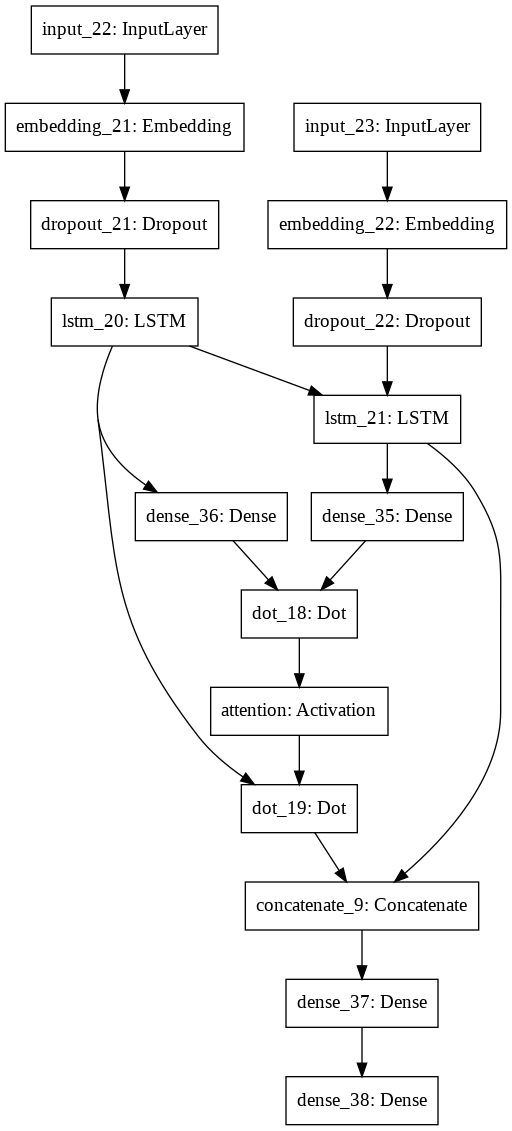

In [63]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='multiple_inputs.png')

In [64]:
# checkpoint
filename = 'model.h1.22_Nov_19'

checkpoint = ModelCheckpoint(filename, monitor='val_loss', save_best_only=True, mode='min')              
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)

# train model
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, validation_split=0.3,
                              callbacks=[es, checkpoint], verbose=1, batch_size=64, epochs=10)

Train on 7000 samples, validate on 3000 samples
Epoch 1/10
7000/7000 [==============================] - 108s 15ms/sample - loss: 2.5295 - acc: 0.3373 - precision: 0.0781 - val_loss: 2.1920 - val_acc: 0.3429 - val_precision: 0.1008
Epoch 2/10
7000/7000 [==============================] - 100s 14ms/sample - loss: 2.0795 - acc: 0.3405 - precision: 0.1006 - val_loss: 1.9786 - val_acc: 0.3429 - val_precision: 0.1162
Epoch 3/10
7000/7000 [==============================] - 100s 14ms/sample - loss: 1.8776 - acc: 0.3405 - precision: 0.1001 - val_loss: 1.7995 - val_acc: 0.3429 - val_precision: 0.1036
Epoch 4/10
7000/7000 [==============================] - 100s 14ms/sample - loss: 1.7508 - acc: 0.3405 - precision: 0.0957 - val_loss: 1.6913 - val_acc: 0.3429 - val_precision: 0.0965
Epoch 5/10
7000/7000 [==============================] - 100s 14ms/sample - loss: 1.6656 - acc: 0.3424 - precision: 0.0942 - val_loss: 1.6244 - val_acc: 0.3439 - val_precision: 0.0960
Epoch 6/10
7000/7000 [===============

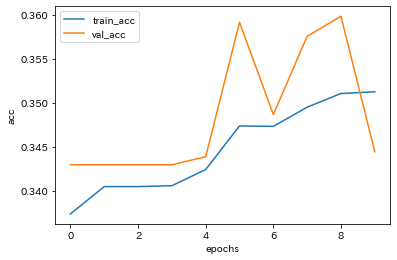

In [69]:
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend(["train_acc", "val_acc"])
plt.show()

In [33]:
# load model
model = load_model('model.h1.22_Nov_19')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [71]:
for i in encoder_input_data[:10]:
  decoder_input = np.zeros(shape=(len(i), out_timesteps))
  decoder_input[:,0] = start_word
  output = model.predict([i, decoder_input]).argmax(axis=2)
  print(output)

TypeError: ignored

In [43]:
decoder_input[0]

array([21.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [0]:
text = ""
for i in decoder_input[0]:
  if i == 22:
    break
  text += reverse_target_char[i]


print(text)

# define testing model

In [0]:
# encoder model
encoder_input = model.input[0] # enocoder input
encoder_output, state_h, state_c = model.layers[6].output # encoder lstm
encoder_staet = [state_h, state_c]
encoder_model = Model(encoder_input, encoder_staet)
encoder_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 1024)        5763072   
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 1024)        0         
_________________________________________________________________
lstm_4 (LSTM)                [(None, None, 1024), (Non 8392704   
Total params: 14,155,776
Trainable params: 14,155,776
Non-trainable params: 0
_________________________________________________________________


In [0]:
# decoder model
decoder_input = model.input[1] # decoder input
decoder_state_input_h = Input(shape=(units,))
decoder_state_input_c = Input(shape=(units,))
decoder_state_input = [decoder_state_input_h, decoder_state_input_c]
decoder_emb = model.layers[3]
deocder_emb = decoder_emb(decoder_input)
decoder_lstm = model.layers[7] # decoder lstm
decoder_output, dec_state_h, dec_state_c = decoder_lstm(deocder_emb, initial_state=decoder_state_input)
decoder_state = [dec_state_h, dec_state_c]


decoder_dense = model.layers[13]
decoder_output = decoder_dense(decoder_output)

decoder_model = Model([decoder_input] + decoder_state_input, [decoder_output] + decoder_state)
decoder_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 1024)   7830528     input_8[0][0]                    
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 1024)]       0                                            
____________________________________________________________________________________________

In [0]:
encoder_input_data[0]
state_1, state_2 = encoder_model.predict(a)

In [0]:
a = encoder_input_data[4]


In [0]:
en_state = [state_1, state_2]

# populate the first character of target seq
target_seq = np.zeros((1, 1))
target_seq[0, 0] = target_token_index["START_"]

# loop for batch of sequences
stop_condition = False
decoder_sentence = ''

while not stop_condition:
    output_token, h, c = decoder_model.predict([target_seq] + en_state)

    sampled_token_index = np.argmax(output_token[0, -1, :])
    sampled_char = reverse_target_char[sampled_token_index]
    decoder_sentence += ' ' + sampled_char


    # stop condition
    if sampled_char == "_END" or len(decoder_sentence) > max_len_input:
      stop_condition = True
    

    # update the target sequence
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = sampled_token_index

    # update states
    en_state = [h, c]


In [0]:
def decoder_seq(input_seq):
    # encoder the input seq as vector
    output_en, a, b = encoder_model.predict(input_seq)
    enc_output = encoder_model.layers[3].output[0]
    en_state = [a, b]
    # generate empty target sequence
    target_seq = np.zeros((1, max_len_target))
    # populate the first character of target seq
    target_seq[0, 0] = target_token_index["START_"]

    # loop for batch of sequences
    stop_condition = False
    decoder_sentence = ''
    decoder_model = define_decoder(enc_output)

    while not stop_condition:
        output_token, h, c = decoder_model.predict([target_seq] + en_state)

        sampled_token_index = np.argmax(output_token[0, -1, :])
        sampled_char = reverse_target_char[sampled_token_index]
        decoder_sentence += ' ' + sampled_char


        # stop condition
        if sampled_char == "_END" or len(decoder_sentence) > max_len_input:
          stop_condition = True
        

        # update the target sequence
        target_seq = np.zeros((1, max_len_target))
        target_seq[0, 0] = sampled_token_index

        # update states
        en_state = [h, c]
    
    return decoder_sentence

In [0]:
train_gen = generate_batch(X_test, Y_test, 1)
k = -1

In [0]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoder_sentence = decoder_seq(input_seq)
print("input english %s" % X_test[k:k+1].values[0])
print("actual %s" % Y_test[k:k+1].values[0][6:-4])
print("predict %s" % decoder_sentence[:-4] )

input english who is behind the camera flash ? 
actual  カメラの明かりだ 後ろに誰がいる ?  
predict  言うの 飲み直しだよ どうなってしまうか もっと心臓に ヘリが到着しました ヘリが到着


In [0]:
decoder_sentence

' その名前もきっとー 様な現実に慣らすこと 誰もそんなことは お連れしました ことになりかねないので'

In [0]:
from nltk.translate.bleu_score import corpus_bleu

# calculate BLEU score
print('BLEU corpus: %f' % corpus_bleu(list(Y_train.values[6:-4]), predicted))
# from nltk.translate.bleu_score import sentence_bleu
# print("BLUE  sentense: %f" % sentence_bleu(actual, predicted))